<a href="https://colab.research.google.com/github/vtu26557-Charitha/machine-learning/blob/main/task%207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.9 MB/s eta 0:00:00

Learned transition matrix:
 [[0.00577184 0.98779438 0.00643378]
 [0.692706   0.06019411 0.24709989]
 [0.05871615 0.06990988 0.87137396]]

Accuracy: 0.5275

Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      0.53      0.69       630
   Infection       0.00      0.00      0.00       270
     Chronic       0.52      1.00      0.68       300

    accuracy                           0.53      1200
   macro avg       0.51      0.51      0.46      1200
weighted avg       0.65      0.53      0.53      1200



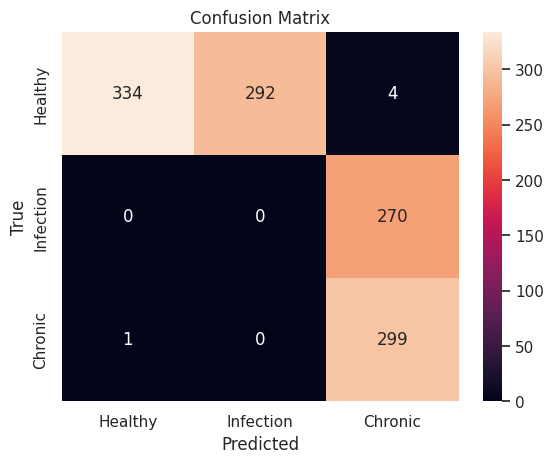

In [1]:
!pip install -q hmmlearn scikit-learn pandas matplotlib seaborn

import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


np.random.seed(42)
n_states = 3
state_names = ["Healthy", "Infection", "Chronic"]
n_sequences = 30
seq_length = 40

true_startprob = np.array([0.9, 0.08, 0.02])
true_transmat = np.array([
    [0.85, 0.10, 0.05],
    [0.20, 0.70, 0.10],
    [0.10, 0.05, 0.85],
])
means = np.array([[36.6, 70],[38.5, 95],[37.2, 85]])
covars = np.array([[[0.1,0.5],[0.5,9]],[[0.3,1],[1,16]],[[0.2,0.7],[0.7,12]]])

observations, lengths, true_states_concat = [], [], []
for _ in range(n_sequences):
    seq_obs, seq_states = [], []
    cur_state = np.random.choice(n_states, p=true_startprob)
    for _ in range(seq_length):
        obs = np.random.multivariate_normal(means[cur_state], covars[cur_state])
        seq_obs.append(obs); seq_states.append(cur_state)
        cur_state = np.random.choice(n_states, p=true_transmat[cur_state])
    observations.append(seq_obs)
    lengths.append(seq_length)
    true_states_concat.extend(seq_states)

X = np.vstack(observations)
true_states_concat = np.array(true_states_concat)


model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, random_state=42)
model.fit(X, lengths)


pred_states = []
idx = 0
for L in lengths:
    _, state_seq = model.decode(X[idx:idx+L], algorithm="viterbi")
    pred_states.extend(state_seq)
    idx += L
pred_states = np.array(pred_states)


from scipy.optimize import linear_sum_assignment
cost = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        cost[i, j] = np.sum((pred_states == i) & (true_states_concat == j))
row_ind, col_ind = linear_sum_assignment(-cost)
mapping = {r:c for r,c in zip(row_ind,col_ind)}
mapped_pred = np.array([mapping[s] for s in pred_states])


print("\nLearned transition matrix:\n", model.transmat_)
print("\nAccuracy:", accuracy_score(true_states_concat, mapped_pred))
print("\nClassification Report:\n", classification_report(true_states_concat, mapped_pred, target_names=state_names))

cm = confusion_matrix(true_states_concat, mapped_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=state_names, yticklabels=state_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()